<a href="https://colab.research.google.com/github/gverafei/artificial-networks-technologies/blob/main/tarea2/delta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 2**
Sep 2025



## Configure virtual environment

Only execute these lines the first time. It will ask you to create a new virtual environment. In notebook, it might ask you to select a kernel from the upper right corner.

In [2]:
!python3 -m venv .venv

In [3]:
!source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

In [4]:
!pip install --upgrade pip --quiet

In [6]:
!pip install prettytable tqdm --quiet

In [7]:
!pip install numpy --quiet

In [8]:
!pip install matplotlib --quiet

## 1. Primero vamos a probar usando la función de numpy llamada tanh(a).

In [9]:
import numpy as np

# ----------------------------
# Activación tanh y derivada (en función de y)
# ----------------------------
def tanh(a):
    return np.tanh(a)

def dtanh_from_y(y):
    return 1.0 - y**2  # para y = tanh(a)

# ----------------------------
# Entrenamiento: Regla Delta (generalizada) con x1 >= 1 (sesgo embebido)
# ----------------------------
def train_delta_with_bias_input(
    X,           # shape: (N, 3) -> columnas [x1, x2, x3], con x1=1.0 en todos los patrones
    d,           # shape: (N,) -> salida deseada (bipolar: -1/+1)
    eta=0.03,    # tasa de aprendizaje
    eps=0.05,    # criterio de paro (LMSE <= eps)
    max_epochs=5000,
    activation=tanh,
    dactivation=dtanh_from_y,
    seed=123,
    shuffle=False,
    verbose=True
):
    """
    Entrena una neurona con 3 entradas [x1, x2, x3] donde x1 es el sesgo (constante 1.0).
    Regla delta generalizada:
        Δw = η (d - y) f'(a) x
    """
    rng = np.random.default_rng(seed)
    N, d_in = X.shape
    assert d_in == 3, "Se esperan tres entradas: x1 (sesgo), x2 y x3."

    # Pesos iniciales (w1, w2, w3) en cero como en la clase
    w = np.zeros(3, dtype=float)

    lmse_hist = []

    for epoch in range(1, max_epochs + 1):
        # Barajar patrones por época (si se desea)
        if shuffle:
            idx = rng.permutation(N)
            X_epoch, d_epoch = X[idx], d[idx]
        else:
            X_epoch, d_epoch = X, d

        sq_errors = []

        for x_vec, target in zip(X_epoch, d_epoch):
            # a = w1*x1 + w2*x2 + w3*x3
            a = np.dot(w, x_vec)
            y = activation(a)
            e = target - y
            g = dactivation(y)  # f'(a)

            # Δw = η e g x  (vectorial)
            w += eta * e * g * x_vec

            sq_errors.append(0.5 * e**2)

        lmse = float(np.mean(sq_errors))
        lmse_hist.append(lmse)

        # if verbose and (epoch == 1 or epoch % 50 == 0 or lmse <= eps):
        #     print(f"Epoch {epoch:4d} | LMSE = {lmse:.6f} | w = {w}")
        print(f"Epoch {epoch:4d} | LMSE = {lmse:.6f} | w = {w}")

        if lmse <= eps:
            if verbose:
                print(f"\nConvergencia alcanzada: LMSE promedio {lmse:.6f} ≤ {eps} en la época {epoch}.")
            return w, lmse_hist, epoch

    if verbose:
        print("\nSe alcanzó max_epochs sin cumplir el criterio de paro.")
    return w, lmse_hist, max_epochs

# ----------------------------
# Datos: AND bipolar con sesgo como x1 = 1
# ----------------------------
# x1 = 1.0 (sesgo), x2, x3 en {-1, +1}
X = np.array([
    [+1.0, -1.0,  -1.0],  # patrón 1
    [+1.0, -1.0,  +1.0],  # patrón 2
    [+1.0, +1.0,  -1.0],  # patrón 3
    [+1.0, +1.0,  +1.0],  # patrón 4
], dtype=float)

# d (salida deseada) en bipolar para AND
# AND: solo (+1, +1) -> +1; el resto -> -1
d = np.array([-1.0, -1.0, -1.0, +1.0], dtype=float)

# ----------------------------
# Entrenamiento
# ----------------------------
w, lmse_hist, epochs_ran = train_delta_with_bias_input(
    X=X,
    d=d,
    eta=0.03,
    eps=0.05,
    max_epochs=5000,
    activation=tanh,
    dactivation=dtanh_from_y,
    seed=123,
    shuffle=False,
    verbose=True
)

# ----------------------------
# Evaluación final
# ----------------------------
def predict_with_bias_input(X, w, activation=tanh):
    # X ya incluye x3=1 por patrón
    a = X @ w
    return activation(a)

y_pred = predict_with_bias_input(X, w, tanh)

print("\nPredicciones finales (tanh):")
for x_vec, y_hat, target in zip(X, y_pred, d):
    x1, x2, x3 = x_vec
    print(f"x1={x1:+.0f}, x2={x2:+.0f}, x3={x3:.0f} -> y={y_hat:+.4f}  (d={target:+.0f})")

# Clasificación bipolar con umbral 0
y_cls = np.where(y_pred >= 0.0, +1.0, -1.0)
acc = np.mean(y_cls == d)
print(f"\nExactitud (umbral 0, bipolar): {acc*100:.1f}%")

print(f"\nPesos finales: w1={w[0]:+.4f}, w2={w[1]:+.4f}, w3={w[2]:+.4f} (x1 es el sesgo)")


    


Epoch    1 | LMSE = 0.499748 | w = [-0.05820118  0.05994701  0.06174321]
Epoch    2 | LMSE = 0.418733 | w = [-0.10869916  0.11204724  0.11544049]
Epoch    3 | LMSE = 0.358483 | w = [-0.15207844  0.15680071  0.16154021]
Epoch    4 | LMSE = 0.313843 | w = [-0.18969215  0.19553801  0.20136977]
Epoch    5 | LMSE = 0.279939 | w = [-0.22284056  0.22957136  0.2362622 ]
Epoch    6 | LMSE = 0.253334 | w = [-0.25253787  0.25994224  0.26728903]
Epoch    7 | LMSE = 0.231808 | w = [-0.27952523  0.28742373  0.29525501]
Epoch    8 | LMSE = 0.213932 | w = [-0.30433743  0.31258177  0.32075577]
Epoch    9 | LMSE = 0.198769 | w = [-0.3273637   0.33583358  0.34423483]
Epoch   10 | LMSE = 0.185688 | w = [-0.34889228  0.3574915   0.36602702]
Epoch   11 | LMSE = 0.174244 | w = [-0.36914108  0.37779357  0.38638929]
Epoch   12 | LMSE = 0.164121 | w = [-0.38827841  0.3969247   0.40552213]
Epoch   13 | LMSE = 0.155083 | w = [-0.40643699  0.41503107  0.42358455]
Epoch   14 | LMSE = 0.146951 | w = [-0.42372359  0.

## 2. Luego vamos a probar usando la función que vimos en clase con exp().

In [10]:
import math as math
import numpy as np

# ----------------------------
# Activación tanh y derivada (en función de y)
# ----------------------------

def tanh_from_class(a):
    return (1 - math.exp(-a)) / (1 + math.exp(-a))

# ----------------------------
# Entrenamiento: Regla Delta (generalizada) con x1 >= 1 (sesgo embebido)
# ----------------------------
def train_delta_with_bias_input(
    X,           # shape: (N, 3) -> columnas [x1, x2, x3], con x1=1.0 en todos los patrones
    d,           # shape: (N,) -> salida deseada (bipolar: -1/+1)
    eta=0.03,    # tasa de aprendizaje
    eps=0.05,    # criterio de paro (LMSE <= eps)
    max_epochs=5000,
    activation=tanh,
    dactivation=dtanh_from_y,
    seed=123,
    shuffle=False,
    verbose=True
):
    """
    Entrena una neurona con 3 entradas [x1, x2, x3] donde x1 es el sesgo (constante 1.0).
    Regla delta generalizada:
        Δw = η (d - y) f'(a) x
    """
    rng = np.random.default_rng(seed)
    N, d_in = X.shape
    assert d_in == 3, "Se esperan tres entradas: x1 (sesgo), x2 y x3."

    # Pesos iniciales (w1, w2, w3) en cero como en la clase
    w = np.zeros(3, dtype=float)

    lmse_hist = []

    for epoch in range(1, max_epochs + 1):
        # Barajar patrones por época (si se desea)
        if shuffle:
            idx = rng.permutation(N)
            X_epoch, d_epoch = X[idx], d[idx]
        else:
            X_epoch, d_epoch = X, d

        sq_errors = []

        for x_vec, target in zip(X_epoch, d_epoch):
            # a = w1*x1 + w2*x2 + w3*x3
            a = np.dot(w, x_vec)
            y = activation(a)
            e = target - y
            g = dactivation(y)  # f'(a)

            # Δw = η e g x  (vectorial)
            w += eta * e * g * x_vec

            sq_errors.append(0.5 * e**2)

        lmse = float(np.mean(sq_errors))
        lmse_hist.append(lmse)

        # if verbose and (epoch == 1 or epoch % 50 == 0 or lmse <= eps):
        #     print(f"Epoch {epoch:4d} | LMSE = {lmse:.6f} | w = {w}")
        print(f"Epoch {epoch:4d} | LMSE = {lmse:.6f} | w = {w}")

        if lmse <= eps:
            if verbose:
                print(f"\nConvergencia alcanzada: LMSE promedio {lmse:.6f} ≤ {eps} en la época {epoch}.")
            return w, lmse_hist, epoch

    if verbose:
        print("\nSe alcanzó max_epochs sin cumplir el criterio de paro.")
    return w, lmse_hist, max_epochs

# ----------------------------
# Datos: AND bipolar con sesgo como x1 = 1
# ----------------------------
# x1 = 1.0 (sesgo), x2, x3 en {-1, +1}
X = np.array([
    [+1.0, -1.0,  -1.0],  # patrón 1
    [+1.0, -1.0,  +1.0],  # patrón 2
    [+1.0, +1.0,  -1.0],  # patrón 3
    [+1.0, +1.0,  +1.0],  # patrón 4
], dtype=float)

# d (salida deseada) en bipolar para AND
# AND: solo (+1, +1) -> +1; el resto -> -1
d = np.array([-1.0, -1.0, -1.0, +1.0], dtype=float)

# ----------------------------
# Entrenamiento
# ----------------------------
w, lmse_hist, epochs_ran = train_delta_with_bias_input(
    X=X,
    d=d,
    eta=0.03,
    eps=0.05,
    max_epochs=5000,
    activation=tanh_from_class,
    dactivation=dtanh_from_y,
    seed=123,
    shuffle=False,
    verbose=True
)

# ----------------------------
# Evaluación final
# ----------------------------
def predict_with_bias_input(X, w, activation=tanh):
    # X ya incluye x3=1 por patrón
    a = X @ w
    return activation(a)

y_pred = predict_with_bias_input(X, w, tanh)

print("\nPredicciones finales (tanh):")
for x_vec, y_hat, target in zip(X, y_pred, d):
    x1, x2, x3 = x_vec
    print(f"x1={x1:+.0f}, x2={x2:+.0f}, x3={x3:.0f} -> y={y_hat:+.4f}  (d={target:+.0f})")

# Clasificación bipolar con umbral 0
y_cls = np.where(y_pred >= 0.0, +1.0, -1.0)
acc = np.mean(y_cls == d)
print(f"\nExactitud (umbral 0, bipolar): {acc*100:.1f}%")

print(f"\nPesos finales: w1={w[0]:+.4f}, w2={w[1]:+.4f}, w3={w[2]:+.4f} (x1 es el sesgo)")


Epoch    1 | LMSE = 0.499940 | w = [-0.05910016  0.05998661  0.06088614]
Epoch    2 | LMSE = 0.457094 | w = [-0.11442979  0.11617101  0.11793026]
Epoch    3 | LMSE = 0.419741 | w = [-0.16593236  0.16848247  0.17104989]
Epoch    4 | LMSE = 0.387464 | w = [-0.21375701  0.21706089  0.22037773]
Epoch    5 | LMSE = 0.359650 | w = [-0.25817382  0.26217121  0.26617513]
Epoch    6 | LMSE = 0.335639 | w = [-0.29950575  0.30413435  0.30876219]
Epoch    7 | LMSE = 0.314810 | w = [-0.33808347  0.34328129  0.34847098]
Epoch    8 | LMSE = 0.296624 | w = [-0.37421986  0.37992676  0.38561859]
Epoch    9 | LMSE = 0.280628 | w = [-0.40819805  0.41435675  0.42049425]
Epoch   10 | LMSE = 0.266453 | w = [-0.44026767  0.44682442  0.45335475]
Epoch   11 | LMSE = 0.253798 | w = [-0.47064563  0.47755047  0.48442466]
Epoch   12 | LMSE = 0.242422 | w = [-0.49951882  0.50672573  0.51389873]
Epoch   13 | LMSE = 0.232127 | w = [-0.5270478   0.53451463  0.54194524]
Epoch   14 | LMSE = 0.222756 | w = [-0.55337036  0.

## Esto es adicional: Graficamos LMSE Vs Ephocs para ver la convergencia de Delta

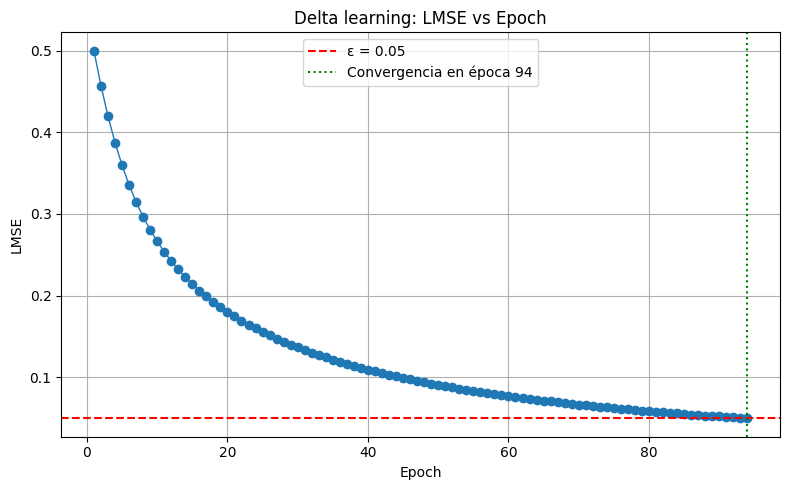

In [11]:
# === Gráfica LMSE vs Epoch ===
import matplotlib.pyplot as plt
import numpy as np

eps_used = 0.05  # mismo epsilon que se usó en el entrenamiento
epochs = np.arange(1, len(lmse_hist) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, lmse_hist, marker='o', linewidth=1)
plt.axhline(y=eps_used, color='red', linestyle='--', label=f'ε = {eps_used}')
plt.axvline(x=epochs_ran, color='green', linestyle=':', label=f'Convergencia en época {epochs_ran}')

plt.title('Delta learning: LMSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('LMSE')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Guardar imagen
plt.savefig("figures/convergencia.png", dpi=500)
plt.show()
